In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader

# 1. 使用DataLoader读取数据集
# 注释部分为对于MNIST数据集的标准化处理

batch_size_train = 64
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./mnist_data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                               # ,torchvision.transforms.Normalize((0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./mnist_data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                                 # ,torchvision.transforms.Normalize((0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [5]:
data_test = enumerate(test_loader)
batch_idx, (data_test_pic, data_test_label) = next(data_test)
print(batch_idx)
print(data_test_pic[0][0])
print(data_test_label[0])

0
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.00

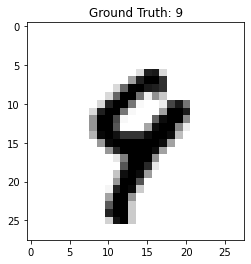

In [50]:
plt.imshow(data_test_pic[0][0], cmap="binary")
plt.title("Ground Truth: {}".format(data_test_label[0]))
plt.show()

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=(5,5))
        self.conv2 = nn.Conv2d(10, 20, kernel_size=(5,5))
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,1)

In [14]:
network = Net()
learning_rate = 0.01
momentum = 0.5
optimizer = torch.optim.SGD(network.parameters(), lr = learning_rate, momentum=momentum)

In [15]:
train_epochs = 3
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(train_epochs + 1)]

In [16]:
log_interval = 100
def train(epoch):
  network.train()
  for batch_idx, (data_train_pic, data_train_label) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data_train_pic)
    loss = F.nll_loss(output, data_train_label)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data_train_pic), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './model/model.pth')
      torch.save(optimizer.state_dict(), './model/optimizer.pth')

In [36]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

test()
for epoch in range(1, train_epochs + 1):
  train(epoch)
  test()

In [17]:
def test_n():
  network.eval()
  output = network(data_test_pic)
  test_loss = F.nll_loss(output,data_test_label)
  test_losses.append(test_loss.item())
  output_label = torch.argmax(output,1)
  accu = output_label.eq(data_test_label).sum()
  print('\nTest accu: {:.4f}. loss: {:.4f}\n'.format(accu/len(data_test_label),test_loss))

test_n()
for epoch in range(1, train_epochs + 1):
  train(epoch)
  test_n()



Test accu: 0.0940. loss: 2.3140

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306257
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.265684
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.096262
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.695201
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.017885
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.689446
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.701728
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.926958
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.695750
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.832465

Test accu: 0.9080. loss: 0.3453

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.523469
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.484867
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.574185
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.564033
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.757248
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.375098
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.319220
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.534558
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.4

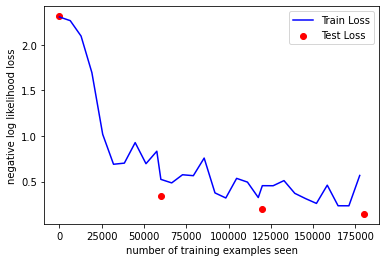

In [18]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

tensor([[3.9520e-02, 2.3961e-04, 9.7688e-04, 7.0488e-03, 2.5858e-03, 8.9536e-01,
         2.2145e-02, 5.5720e-04, 1.9889e-02, 1.1678e-02]],
       grad_fn=<SoftmaxBackward>)


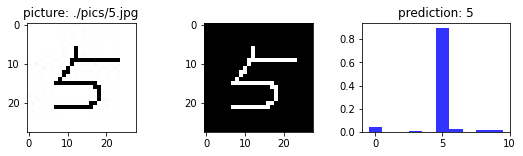

In [21]:
def predict_single_pic(picname):
    img = Image.open(picname)
    plt.figure(figsize=(9,2))
    plt.subplot(1,3,1)
    plt.title("picture: {}".format(picname))
    plt.imshow(img)

    reIm = img.resize((28,28), Image.ANTIALIAS)
    im_arr = np.array(reIm.convert('L'))
    threshold= 50
    for i in range(28):
        for j in range(28):
            im_arr[i][j] = 255 if im_arr[i][j]<threshold else 0
            im_arr[i][j] = im_arr[i][j]/255

    #这一步的reshpae要注意
    img_ready = im_arr.reshape([1,1,28,28])

    # print(img_ready)
    plt.subplot(1,3,2)
    plt.imshow(img_ready[0][0],cmap="gray")

    c = torch.tensor(img_ready, dtype=torch.float)
    network.eval()
    out_img = network.forward(c)
    out_img = torch.softmax(out_img,1)
    print(out_img)
    result = torch.argmax(out_img)
    plt.subplot(1,3,3)
    plt.bar(x=range(10), height=out_img[0].detach().numpy(), width=1, alpha=0.8, color='blue', label="the")
    plt.title("prediction: {}".format(result))
    plt.show()

predict_single_pic("./pics/5.jpg")

tensor([[8.9373e-01, 3.3382e-04, 7.3426e-02, 1.5200e-03, 5.3896e-03, 2.4146e-03,
         9.1319e-03, 5.7219e-04, 3.8228e-03, 9.6582e-03]],
       grad_fn=<SoftmaxBackward>)


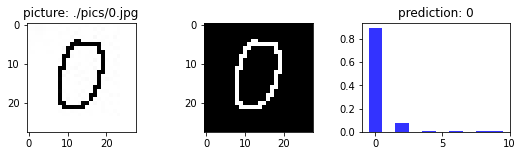

tensor([[0.0435, 0.0099, 0.0077, 0.5201, 0.0022, 0.2975, 0.0026, 0.0910, 0.0033,
         0.0221]], grad_fn=<SoftmaxBackward>)


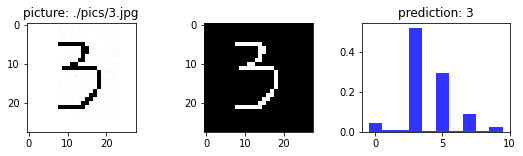

tensor([[4.8599e-03, 4.4266e-04, 2.5594e-03, 1.6268e-03, 1.9714e-02, 3.9350e-01,
         5.2900e-01, 3.4604e-05, 4.7398e-02, 8.5646e-04]],
       grad_fn=<SoftmaxBackward>)


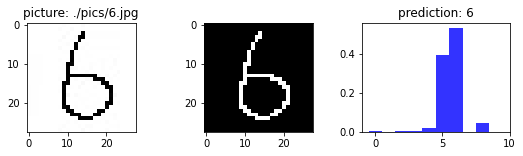

tensor([[2.4620e-07, 8.8023e-04, 9.4480e-01, 1.6355e-02, 1.2391e-09, 3.8405e-08,
         8.0481e-10, 2.2993e-02, 1.4969e-02, 1.3119e-06]],
       grad_fn=<SoftmaxBackward>)


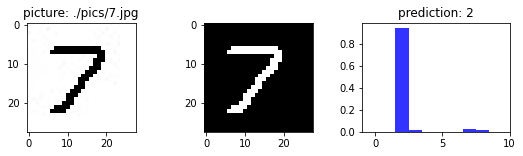

tensor([[0.0061, 0.1738, 0.0194, 0.0694, 0.1640, 0.0601, 0.0104, 0.0914, 0.1076,
         0.2977]], grad_fn=<SoftmaxBackward>)


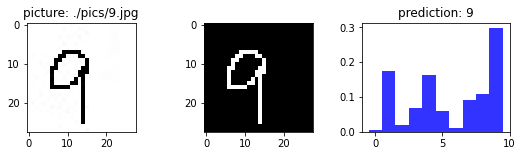

In [20]:
predict_single_pic("./pics/0.jpg")
predict_single_pic("./pics/3.jpg")
predict_single_pic("./pics/6.jpg")
predict_single_pic("./pics/7.jpg")
predict_single_pic("./pics/9.jpg")

In [2]:
network = Net()
network_state_dict = torch.load('model.pth')
network.load_state_dict(network_state_dict)


NameError: name 'torch' is not defined

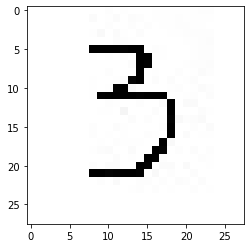